In [1]:
import jax
import jax.numpy as jnp
from jax.tree_util import tree_flatten, tree_unflatten, register_pytree_node
from jax import random, grad, jit, vmap, nn, value_and_grad
from jax.scipy.special import logsumexp
import random as r
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# shuffle up the words
import random as r
r.seed(42)
r.shuffle(words)

In [5]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = jnp.array(X)
  Y = jnp.array(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

(182625, 8) (182625,)
(22655, 8) (22655,)
(22866, 8) (22866,)


In [6]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [31]:
class Linear:

    def __init__(self, fan_in, fan_out, key, bias_used=True, weight=None, bias=None):
        key, _ = random.split(key)
        self.key = key

        if weight != None:
            self.weight = weight
            self.bias = bias
        else:
            self.weight = random.normal(key, (fan_in, fan_out)) / fan_in**0.5
            self.bias = jnp.zeros(fan_out) if bias_used else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1, gamma=None, beta=None):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        if gamma != None and beta != None:
            self.gamma = gamma
            self.beta = beta
        else:
            self.gamma = jnp.ones(dim)
            self.beta = jnp.zeros(dim)
        # buffers (trained with a running momentum update)
        self.running_mean = jnp.zeros(dim)
        self.running_var = jnp.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = jnp.mean(x, keepdims=True) # batch mean
            xvar = jnp.std(x, keepdims=True) + self.eps # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / jnp.sqrt(xvar) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    def __call__(self, x):
        self.out = jnp.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    

class Embedding:
    def __init__(self, num_embeddings, embedding_dim, key, weight=None):
        key, _ = random.split(key)
        self.key = key

        if weight != None:
            self.weight = weight
        else:
            self.weight = random.normal(key, (num_embeddings, embedding_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    

class Flatten:
    def __call__(self, x):
        self.out = jnp.reshape(x, (x.shape[0], -1))
        return self.out
    
    def parameters(self):
        return []


In [32]:
register_pytree_node(Linear, lambda l: ((l.weight, l.bias), l.key),
                             lambda aux, xs: Linear(xs[0].shape[0], xs[0].shape[1], aux, weight=xs[0], bias=xs[1]))
register_pytree_node(BatchNorm1d, lambda l: ((l.gamma, l.beta), None),
                                  lambda aux, xs: BatchNorm1d(len(xs[0]), gamma=xs[0], beta=xs[1]))
register_pytree_node(Tanh, lambda l: ((), None), lambda _, xs: Tanh())
register_pytree_node(Embedding, lambda l: ((l.weight, ), l.key),
                                lambda aux, xs: Embedding(xs[0].shape[0], xs[0].shape[1], aux, weight=xs[0]))
register_pytree_node(Flatten, lambda l: ((), None), lambda _, xs: Flatten())

In [33]:
n_embd = 10
n_hidden = 100
key = random.PRNGKey(10)

layers = [
    Embedding(vocab_size, n_embd, key), Flatten(),
    Linear(n_embd * block_size, n_hidden, key, bias_used=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, key),
]

# make the last layer less confident
# layers[-1].weight *= 0.1
layers[-1].weight *= 0.1
# apply the gain to all the other layers
for layer in layers[:-1]:
    if isinstance(layer, Linear):
        layer.weight *= 5/3

parameters = [p for layer in layers for p in layer.parameters()]
params, _ = tree_flatten(parameters)
print(len(params))
sum(jnp.size(p) for p in params)

6


11197

In [34]:
def predict(layers, x):
    for layer in layers:
        x = layer(x)
    return x

def cross_entropy_loss(layers, X, Y):
    logits = predict(layers, X)
    counts = jnp.exp(logits - logsumexp(logits, axis=1, keepdims=True)) # logits - logsumexp(logits) ensures that there aren't overflow errors
    probs = counts / jnp.sum(counts, 1, keepdims=True)
    def get_idx(prob, y):
        return -jnp.log(prob[y])
    vectorized_probs = vmap(get_idx)(probs, Y)
    return vectorized_probs.mean()

def update(layers, X, Y, lr=0.1):
    value, grads = value_and_grad(cross_entropy_loss)(layers, X, Y)
    for l, g in zip(layers, grads[1]):
        if isinstance(l, Embedding):
            l.weight = l.weight - lr * g.weight
        elif isinstance(l, Linear):
            l.weight = l.weight - lr * g.weight
            if l.bias is not None: l.bias = l.bias - lr * g.bias
        elif isinstance(l, BatchNorm1d):
            l.gamma = l.gamma - lr * g.gamma
            l.beta = l.beta - lr * g.beta
    return value, layers

In [35]:
epochs = 200000
lossi = []
batch_size = 32

for i in range(epochs):
    # get minibatch
    key, _ = random.split(key)
    ix = random.randint(key, (batch_size, ), 0, Xtr.shape[0]) # create random batch indicies
    Xb, Yb = Xtr[ix], Ytr[ix]

    lr = 0.1 if i < epochs/2 else 0.01
    # out = predict(layers, Xb)
    loss, layers = update(layers, Xb, Yb)
    
    if i % 1000 == 0:
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    lossi.append(jnp.log10(loss).item())

IndexError: tuple index out of range

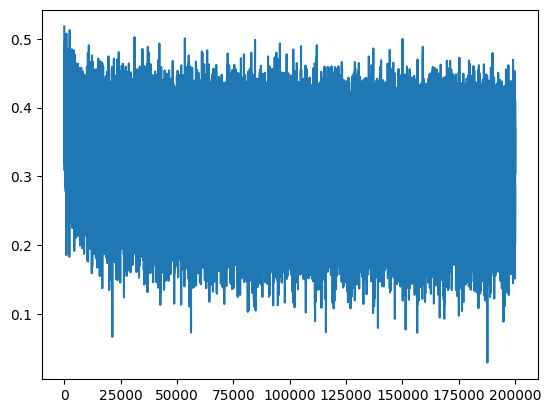

In [13]:
plt.plot(lossi)

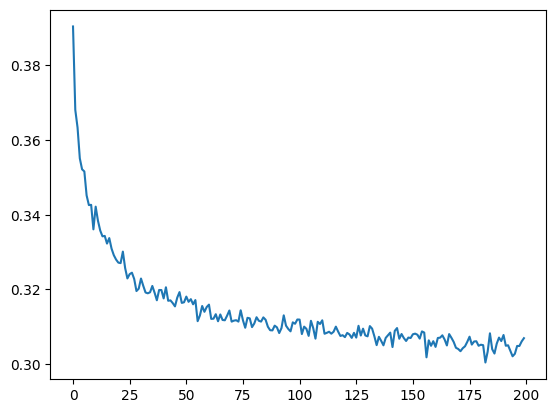

In [14]:
# First, we make the plot nicer by plotting the average loss every 1000 steps
plt.plot(jnp.mean(jnp.reshape(jnp.array(lossi), (-1, 1000)), axis=1))

In [15]:
# evaluate the loss
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  cross_entropy_loss(layers, x, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.33725643157959
val 2.33725643157959


In [17]:
import torch
g = torch.Generator().manual_seed(2147483647)

def sample(parameters, num_words=5):
    for i in range(num_words):
        out = []
        context = [0] * block_size # Initialize to ... (all state tokens)
        while True:
            logits = predict(layers, jnp.array(context).reshape(1, -1))
            probs = nn.softmax(logits, axis=1)

            ix = torch.multinomial(torch.tensor(probs.tolist()), num_samples=1, replacement=True, generator=g).item()
            context = context[1:] + [ix]
            out.append(itos[ix])
            if ix == 0:
                break

        print(''.join(out))

sample(parameters, 20)

cexzen.
jallus.
johziel.
kellynn.
train.
lucan.
katar.
samiyah.
jahsiyah.
zimic.
jenanius.
fraedy.
kaleysa.
sadly.
tiavi.
nyhatlyn.
hunten.
viah.
koudy.
fradin.
